# Reference snowpits

This notebook aims at extracting and plotting the data obtained at each snowpit.

## Imports and functions

In [2]:
import xarray as xr
import dask.array
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy import f2py
import pandas as pd
from datetime import datetime

In [2]:
def median_spacetime_filtering(ds, min_periods_val, time_window=11, x_span=11, y_span=11):
    '''
    Function to apply median filtering in time and space
    Args:
        ds: clean data dataset
        time_window: time windo on which to apply median filter [index]
        x_span: x-span on which to apply filtering, unit [index]
        y_span: y-span on which to apply filtering, unit [index]
    Returns:
    '''
    # TODO take out time median
    # ds['snow_surface'] = ds['mean'].rolling(time=time_window, min_periods=min_periods_val, center=True).median()
    # print(f'---> Median filtering in time with a window of {time_window}')
    ds['snow_surface'] = ds['mean'].rolling({'x': x_span, 'y': y_span}, min_periods=min_periods_val, center=True).median()
    print(f'---> Median filtering in space with a window [{x_span}, {y_span}]')
    
    # note that a skipna argument is available (useful?) in xarray.DataArray.median()


In [3]:
def get_snow_events_bis(ds, x_sel, y_sel, time_window_std):
    '''
    Function that computes the dates of start and end times of snow events (snow accumulation and erosion)
    The events are defined as periods during which the snow-depth rolling standard deviation is higher than 
    a given threshold (set to 0.02 here)
    We distinguish between accumulation and erosion of snow by looking at the snow depth before and after the event
    Args:
        ds: clean dataset with 'snow_surface' variable
        x_sel: x coordinate of the point of interest (index)
        y_sel: y coordinate of the point of interest (index)
        time_window_std: size of the rolling window to compute standard deviation
    Returns:
        start_accumulation_indices: list of time indices corresponding to the start of an accumulation event
        start_erosion_indices: list of time indices corresponding to the end of an accumulation event
        end_accumulation_indices: list of time indices corresponding to the start of an erosion event
        end_erosion_indices: list of time indices corresponding to the end of an erosion event
    '''
    
    stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values
    
    snow_events_occurrences = stdev > 0.015   # booleans           # TODO make this modular
    snow_events_occurrences = np.diff(snow_events_occurrences.astype(int))   # 1 or 0
    start_time_indices = np.where(snow_events_occurrences==1)[0]
    end_time_indices = np.where(snow_events_occurrences==-1)[0]
    
    start_accumulation_indices = []
    start_erosion_indices = []
    end_accumulation_indices = []
    end_erosion_indices = []
    
    for index in range(len(start_time_indices)):
        
        start_date = start_time_indices[index]
        end_date = end_time_indices[index]
    
        start_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=start_date))
        end_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=end_date))
    
        if start_snow_height < end_snow_height:
            start_accumulation_indices.append(start_time_indices[index])
            end_accumulation_indices.append(end_time_indices[index])
        else:
            start_erosion_indices.append(start_time_indices[index])
            end_erosion_indices.append(end_time_indices[index])
        
    return(start_accumulation_indices, start_erosion_indices, end_accumulation_indices, end_erosion_indices)


In [4]:
def get_change_in_snow_depth(ds, start_events, end_events, index_of_event, x_sel, y_sel):
    '''
    Function to get snow height difference (absolute value) before and after an event
    Args:
        ds: dataset containing the snow-depth data ('snow_surface' variable)
        start_events: list of time indices at which the events of interest (accumulation or erosion) started
        end_events: list of time indices at which the events of interest (accumulation or erosion) ended
        index_of_event: index of event of interest in the lists of time indices
        x_sel: index of the x-coordinate of the point of interest
        y_sel: index of the y-coordinate of the point of interest
    Returns:
        difference in snow-depth between the start and end of the event
    '''
    
    start_date = start_events[index_of_event]
    end_date = end_events[index_of_event]
    
    start_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=start_date))
    end_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=end_date))
    difference = abs(end_snow_height - start_snow_height)
    
    return(difference)

## Create dataset

In [5]:
data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})


/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing numbe

In [6]:
# data_dec_jan_fev.isel(x=slice(84,106), y=slice(28,50)).to_netcdf('snow_pit_1.nc')
sp1 = xr.open_dataset('snow_pit_1.nc')


In [7]:
# data_dec_jan_fev.isel(x=slice(105,127), y=slice(39,61)).to_netcdf('snow_pit_2.nc')
sp2 = xr.open_dataset('snow_pit_2.nc')


In [8]:
sp1 = sp1.ffill(dim='time')
median_spacetime_filtering(sp1, 11)
sp1['snow_surface'] = sp1['snow_surface'] - sp1['snow_surface'].min()

sp2 = sp2.ffill(dim='time')
median_spacetime_filtering(sp2, 11)
sp2['snow_surface'] = sp2['snow_surface'] - sp2['snow_surface'].min() 


---> Median filtering in space with a window [11, 11]
---> Median filtering in space with a window [11, 11]


## Get events' timing and plot it

In [9]:
x_sel = 10
y_sel = 10
time_window_std = 23

results_sp1 = get_snow_events_bis(sp1, x_sel, y_sel, time_window_std)
start_accumulation_sp1 = results_sp1[0]
start_erosion_sp1 = results_sp1[1]
end_accumulation_sp1 = results_sp1[2]
end_erosion_sp1 = results_sp1[3]

results_sp2 = get_snow_events_bis(sp2, x_sel, y_sel, time_window_std)
start_accumulation_sp2 = results_sp2[0]
start_erosion_sp2 = results_sp2[1]
end_accumulation_sp2 = results_sp2[2]
end_erosion_sp2 = results_sp2[3]


/tmp/ipykernel_14279/329830003.py:19: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values


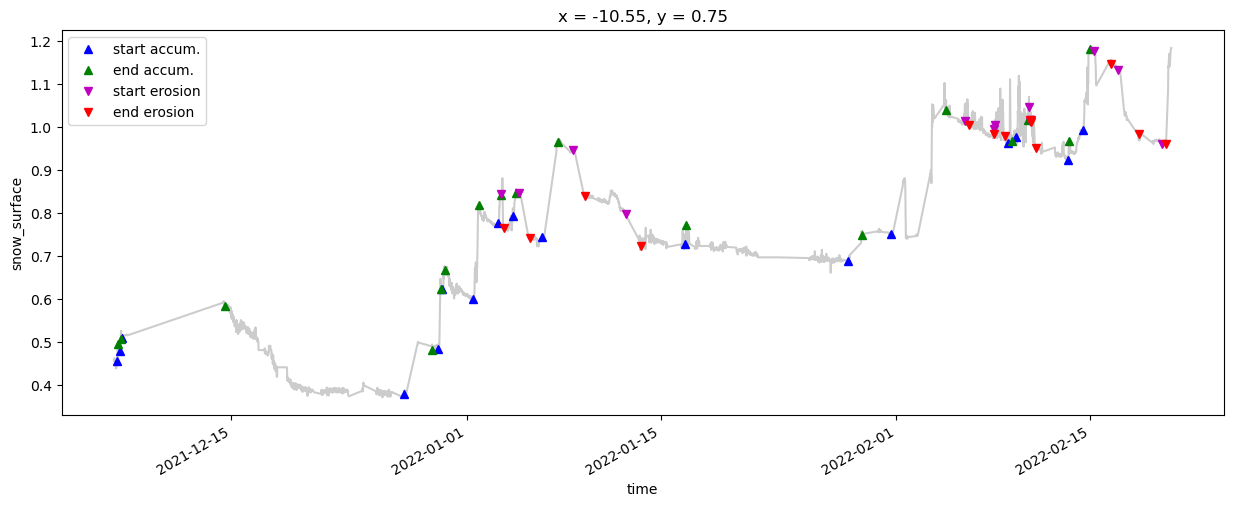

In [10]:
plt.figure(figsize=(15, 5))

sp1.isel(x=x_sel, y=y_sel).snow_surface.plot(c='k', alpha=0.2)

sp1.isel(x=x_sel, y=y_sel, time=start_accumulation_sp1).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.')
sp1.isel(x=x_sel, y=y_sel, time=end_accumulation_sp1).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.')
sp1.isel(x=x_sel, y=y_sel, time=start_erosion_sp1).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion')
sp1.isel(x=x_sel, y=y_sel, time=end_erosion_sp1).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion')

plt.legend()


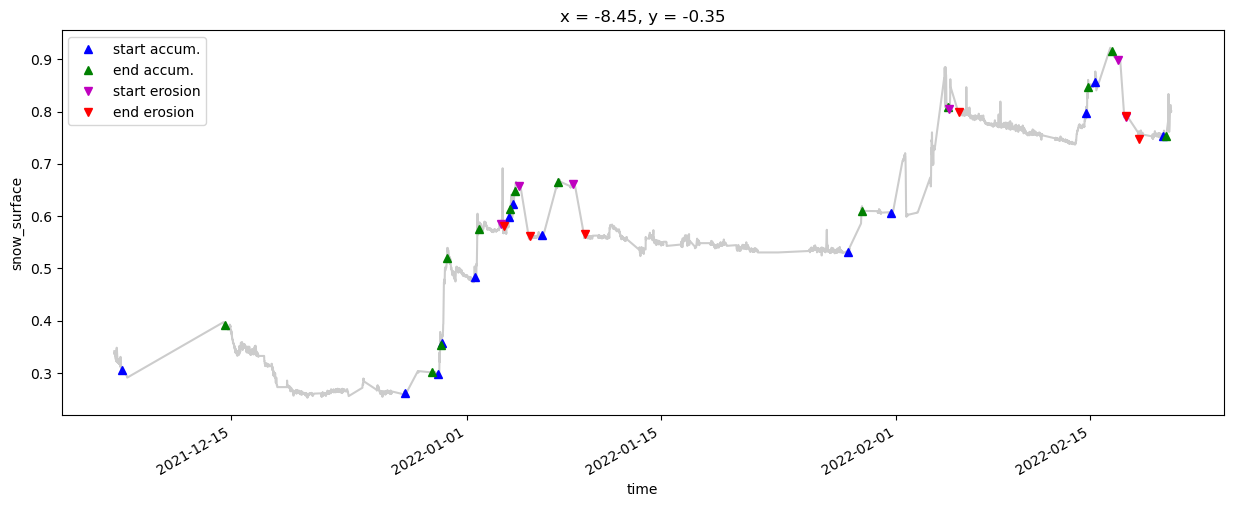

In [11]:
plt.figure(figsize=(15, 5))

sp2.isel(x=x_sel, y=y_sel).snow_surface.plot(c='k', alpha=0.2)

sp2.isel(x=x_sel, y=y_sel, time=start_accumulation_sp2).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.')
sp2.isel(x=x_sel, y=y_sel, time=end_accumulation_sp2).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.')
sp2.isel(x=x_sel, y=y_sel, time=start_erosion_sp2).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion')
sp2.isel(x=x_sel, y=y_sel, time=end_erosion_sp2).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion')

plt.legend()


## Get snow height for each event, convert to swe

#### Snowpit 1

In [12]:
ro_water = 1000      # in kg per m**3
ro_layer = 150      # in kg per m**3

sp1_accumulation_heights = []
sp1_accumulation_duration = []
sp1_swe = []

for index in range(len(start_accumulation_sp1)):
    sp1_accumulation_heights.append(get_change_in_snow_depth(sp1, start_accumulation_sp1, end_accumulation_sp1, index, x_sel, y_sel) * 1000 / 0.01)  # in mm per m**2
    
    start = sp1.time.values[start_accumulation_sp1[index]]
    end = sp1.time.values[end_accumulation_sp1[index]]
    diff = float(end-start) / 1000000000     # in s
    sp1_accumulation_duration.append(diff)
    
    swe = sp1_accumulation_heights[index] * (ro_water/ro_layer) / sp1_accumulation_duration[index]     # in mm per s per m**2
    sp1_swe.append(swe)


#### Snowpit 2

In [13]:
ro_water = 1000      # in kg per m**3
ro_layer = 150      # in kg per m**3

sp2_accumulation_heights = []
sp2_accumulation_duration = []
sp2_swe = []

for index in range(len(start_accumulation_sp2)):
    sp2_accumulation_heights.append(get_change_in_snow_depth(sp2, start_accumulation_sp2, end_accumulation_sp2, index, x_sel, y_sel) * 1000 / 0.01)  # in mm per m**2
    
    start = sp2.time.values[start_accumulation_sp2[index]]
    end = sp2.time.values[end_accumulation_sp2[index]]
    diff = float(end-start) / 1000000000     # in s
    sp2_accumulation_duration.append(diff)
    
    swe = sp2_accumulation_heights[index] * (ro_water/ro_layer) / sp2_accumulation_duration[index]     # in mm per s per m**2
    sp2_swe.append(swe)


## Make dataset (swe per hour) and save files

In [14]:
data_ds_sp1 = np.zeros(2160)
data_start_date = pd.to_datetime('2021-12-01T00:00')

for event_index in range(len(start_accumulation_sp1)):
    starting_time = sp1.time.values[start_accumulation_sp1[event_index]]
    ending_time = sp1.time.values[end_accumulation_sp1[event_index]]
    ending_time_duration = sp1.time.values[end_accumulation_sp1[event_index]+1]

    starting_duration = float((starting_time-data_start_date).total_seconds()) / 3600    # in h
    starting_index = int(starting_duration // 1)

    ending_duration_true_duration = float((ending_time_duration-data_start_date).total_seconds()) / 3600    # in h
    ending_duration = float((ending_time-data_start_date).total_seconds()) / 3600    # in h
    ending_index = int(ending_duration // 1)

    starting_swe = sp1_swe[event_index] * (starting_duration - starting_index)    # percentage of the hour during which it actually precipitated
    ending_swe = sp1_swe[event_index] * (ending_duration_true_duration - ending_index)

    data_ds_sp1[starting_index] += starting_swe
    data_ds_sp1[ending_index] += ending_swe

    for i in range(starting_index+1, ending_index):
        data_ds_sp1[i] += sp1_swe[event_index]


In [15]:
data_ds_sp2 = np.zeros(2160)
data_start_date = pd.to_datetime('2021-12-01T00:00')

for event_index in range(len(start_accumulation_sp2)):
    starting_time = sp2.time.values[start_accumulation_sp2[event_index]]
    ending_time = sp2.time.values[end_accumulation_sp2[event_index]]
    ending_time_duration = sp2.time.values[end_accumulation_sp2[event_index]+1]

    starting_duration = float((starting_time-data_start_date).total_seconds()) / 3600    # in h
    starting_index = int(starting_duration // 1)

    ending_duration_true_duration = float((ending_time_duration-data_start_date).total_seconds()) / 3600    # in h
    ending_duration = float((ending_time-data_start_date).total_seconds()) / 3600    # in h
    ending_index = int(ending_duration // 1)

    starting_swe = sp2_swe[event_index] * (starting_duration - starting_index)    # percentage of the hour during which it actually precipitated
    ending_swe = sp2_swe[event_index] * (ending_duration_true_duration - ending_index)

    data_ds_sp2[starting_index] += starting_swe
    data_ds_sp2[ending_index] += ending_swe

    for i in range(starting_index+1, ending_index):
        data_ds_sp2[i] += sp2_swe[event_index]
 

In [16]:
times = pd.date_range(start='2021-12-01',freq='1H',periods=2160)

# create dataset
ds_sp1 = xr.Dataset({
    'swe': xr.DataArray(
                data   = data_ds_sp1,
                dims   = ['time'],
                coords = {'time': times},
                attrs  = {
                    'units'     : 'mm/s/m**2'
                    }
                )
            }
    )

ds_sp2 = xr.Dataset({
    'swe': xr.DataArray(
                data   = data_ds_sp2,
                dims   = ['time'],
                coords = {'time': times},
                attrs  = {
                    'units'     : 'mm/s/m**2'
                    }
                )
            }
    )

In [17]:
ds_sp1.to_netcdf('snow_pit_1_precip.nc')
ds_sp2.to_netcdf('snow_pit_2_precip.nc')